In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

# if dataset is in drive
#from google.colab import drive
#drive.mount(path := '/drive')
#path += '/MyDrive/MMA/dataset.csv'
# else
path = './dataset.csv'

random_state = 42

In [71]:
df = pd.read_csv(path, low_memory=False).drop(['fight_id', 'f_1', 'f_2', 'finish_time'], axis=1)
df[:1]

,winner,weight_class,result,finish_round,knockdownsA,total_strikes_attA,total_strikes_succA,sig_strikes_attA,sig_strikes_succA,takedown_attA,...,sig_strikes_attB,sig_strikes_succB,takedown_attB,takedown_succB,submission_attB,reversalsB,ctrl_timeB,wins decB,wins subB,wins koB
0,0,2,0,2,0.000556,0.239795,0.161637,0.134006,0.066257,0.014064,...,0.175345,0.082486,0.000988,0.000988,0.0,0.0,0.040564,1,0,1


In [72]:
targets  = df[ts := ['winner', 'result', 'finish_round']]
features = df.drop(ts, axis=1)
targets.shape, features.shape

((2869, 3), (2869, 27))

In [73]:
Xtrain, Ytrain = features[500:], targets[500:]
Xtest, Ytest   = features[:500], targets[:500]

Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((2369, 27), (2369, 3), (500, 27), (500, 3))

# Predicting the winner (A or B)

In [74]:
ytrain = Ytrain['winner']
ytest  = Ytest['winner']

In [75]:
rf_winner = RandomForestClassifier(
    random_state=random_state,
    oob_score=True
).fit(Xtrain, ytrain)

preds_train = rf_winner.predict(Xtrain)
preds_test  = rf_winner.predict(Xtest)

print(f'{accuracy_score(ytrain, preds_train)*100:.1f}%')
print(f'{accuracy_score(ytest, preds_test)*100:.1f}%')

print(f'OOB-Error: {1 - rf_winner.oob_score_:.2f}')

100.0%
49.6%
OOB-Error: 0.49


We are likely overfitting here.

In [76]:
max_depth = np.log2(len(Xtrain)).astype(int)
min_samples = 20
estimators = 300
criterion = 'log_loss'

In [77]:
rf_winner = RandomForestClassifier(
    min_samples_leaf=min_samples,
    random_state=random_state,
    n_estimators=estimators,
    criterion=criterion,
    max_depth=max_depth,
    oob_score=True,
).fit(Xtrain, ytrain)

preds_train = rf_winner.predict(Xtrain)
preds_test  = rf_winner.predict(Xtest)

print(f'Accuracy on training {accuracy_score(ytrain, preds_train)*100:.2f}%')
print(f'Accuracy on testing {accuracy_score(ytest, preds_test)*100:.2f}%')

print(f'OOB-Error: {1 - rf_winner.oob_score_:.2f}')

Accuracy on training 79.99%
Accuracy on testing 54.20%
OOB-Error: 0.47


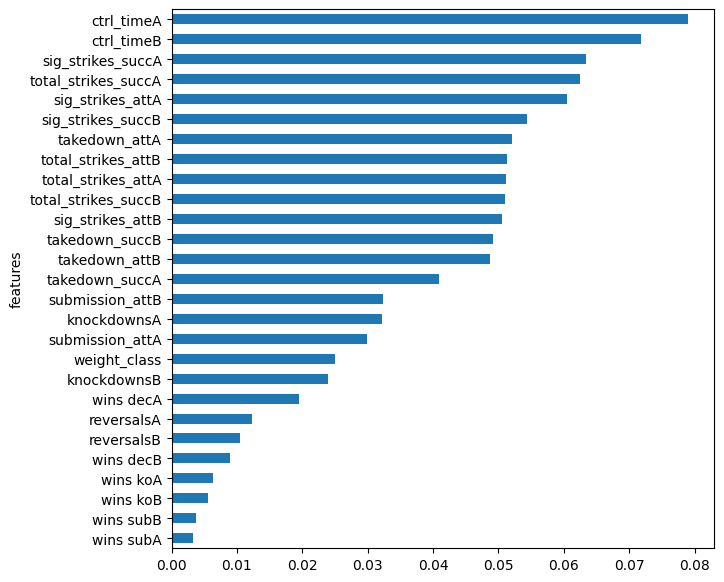

In [78]:
def plot_fi(tree, title=''):
    fi = pd.DataFrame({'features':features.columns, 'imp':tree.feature_importances_}).sort_values('imp')
    fi.plot('features', 'imp', 'barh', figsize=(7,7), legend=False, title=title)

plot_fi(rf_winner)

# Predicting the result (KO, Sub, Dec)

In [79]:
ytrain = Ytrain['result']
ytest  = Ytest['result']

In [80]:
rf_result = RandomForestClassifier(
    min_samples_leaf=min_samples,
    random_state=random_state,
    n_estimators=estimators,
    criterion=criterion,
    max_depth=max_depth,
    oob_score=True,
).fit(Xtrain, ytrain)

preds_train = rf_result.predict(Xtrain)
preds_test  = rf_result.predict(Xtest)

print(f'Accuracy on training {accuracy_score(ytrain, preds_train)*100:.2f}%')
print(f'Accuracy on testing {accuracy_score(ytest, preds_test)*100:.2f}%')

print(f'OOB-Score: {1 - rf_winner.oob_score_:.2f}')

Accuracy on training 57.45%
Accuracy on testing 43.60%
OOB-Score: 0.47


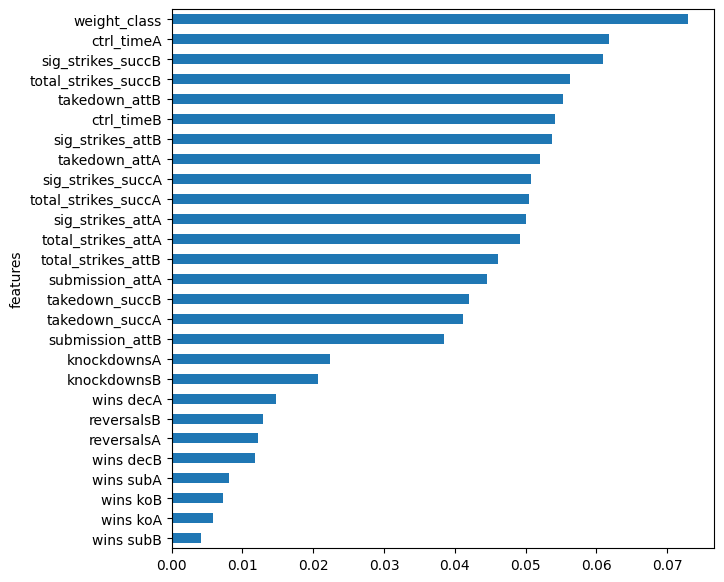

In [81]:
plot_fi(rf_result)

# Predicting the round (1, 2, 3)

In [82]:
ytrain = Ytrain['finish_round']
ytest  = Ytest['finish_round']

In [83]:
rf_round = RandomForestClassifier(
    min_samples_leaf=min_samples,
    random_state=random_state,
    n_estimators=estimators,
    criterion=criterion,
    max_depth=max_depth,
    oob_score=True,
).fit(Xtrain, ytrain)

preds_train = rf_round.predict(Xtrain)
preds_test  = rf_round.predict(Xtest)

print(f'{accuracy_score(ytrain, preds_train)*100:.1f}%')
print(f'{accuracy_score(ytest, preds_test)*100:.2f}%')

58.8%
52.80%


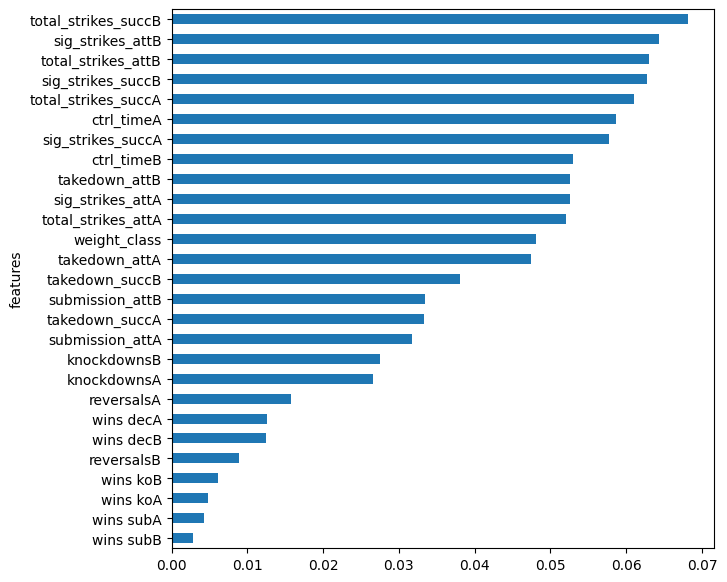

In [84]:
plot_fi(rf_round)

# Eval

In [85]:
def brier_score(targets, probas):
    result = 0.0
    for row, y in zip(probas, targets):
        result += sum([(p - (1 if i == y else 0))**2 for i, p in enumerate(row)])
    return result / len(targets)

In [86]:
probas_winner = rf_winner.predict_proba(Xtest)
preds_winner  = rf_winner.predict(Xtest)

probas_result = rf_result.predict_proba(Xtest)
preds_result  = rf_result.predict(Xtest)

probas_round = rf_round.predict_proba(Xtest)
preds_round  = rf_round.predict(Xtest)

print('\nAccuracies:')
print(accuracy_score(Ytest['winner'], preds_winner)*100)
print(accuracy_score(Ytest['result'], preds_result)*100)
print(accuracy_score(Ytest['finish_round'], preds_round)*100)

print('\nF1:')
print(f1_score(Ytest['winner'], preds_winner))
print(f1_score(Ytest['result'], preds_result, average='weighted'))
print(f1_score(Ytest['finish_round'], preds_round, average='weighted'))

print('\nLog-Losses:')

print(log_loss(Ytest['winner'], probas_winner))
print(log_loss(Ytest['result'], probas_result))
print(log_loss(Ytest['finish_round'], probas_round))

print('\nBrier-Scores:')

print(brier_score(Ytest['winner'], probas_winner))
print(brier_score(Ytest['result'], probas_result))
print(brier_score(Ytest['finish_round'], probas_round))


Accuracies:
54.2
43.6
52.800000000000004

F1:
0.5373737373737374
0.3266800097632414
0.3719808102345416

Log-Losses:
0.6883133759310732
1.0410763751829542
1.030535539051148

Brier-Scores:
0.49506853598646633
0.6327276793308664
0.6143104378462018
